In [3]:
# Advanced ML Models for Air Quality Prediction
# XGBoost, LightGBM with Hyperparameter Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from datetime import datetime
import time

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                            r2_score, mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 70)
print("ADVANCED ML MODELS - AIR QUALITY PREDICTION")
print("=" * 70)

ADVANCED ML MODELS - AIR QUALITY PREDICTION


In [4]:
# =============================================================================
# 1. LOAD DATA
# =============================================================================

print("\n📂 LOADING DATA...")
print("-" * 70)

train_path = Path('../data/processed/features_train.csv')
val_path = Path('../data/processed/features_val.csv')
test_path = Path('../data/processed/features_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f"✓ Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")

# Load feature sets
with open('../data/processed/feature_sets.json', 'r') as f:
    feature_sets = json.load(f)

# Use balanced feature set (50 features)
features = feature_sets['balanced']

# Prepare data
def prepare_data(df, feature_list, target='aqi'):
    available_features = [f for f in feature_list if f in df.columns]
    X = df[available_features].copy()
    y = df[target].copy()
    mask = y.notna()
    X, y = X[mask], y[mask]
    X = X.fillna(X.median())
    return X, y

X_train, y_train = prepare_data(df_train, features)
X_val, y_val = prepare_data(df_val, features)
X_test, y_test = prepare_data(df_test, features)

print(f"\nFeatures: {X_train.shape[1]}")
print(f"Train: {X_train.shape[0]:,} samples")
print(f"Val: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")


📂 LOADING DATA...
----------------------------------------------------------------------
✓ Train: 15,789 | Val: 3,383 | Test: 3,384

Features: 50
Train: 15,789 samples
Val: 3,383 samples
Test: 3,384 samples


In [5]:
# =============================================================================
# 2. EVALUATION FUNCTION
# =============================================================================

def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Comprehensive evaluation"""
    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
    }
    return metrics

In [6]:
# =============================================================================
# 3. XGBOOST - BASELINE CONFIGURATION
# =============================================================================

print("\n" + "=" * 70)
print("🚀 MODEL 1: XGBOOST (Baseline)")
print("=" * 70)

xgb_baseline = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost baseline...")
start_time = time.time()
xgb_baseline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_xgb_train = xgb_baseline.predict(X_train)
y_pred_xgb_val = xgb_baseline.predict(X_val)
y_pred_xgb_test = xgb_baseline.predict(X_test)

print(f"\n✓ Training time: {train_time:.2f} seconds")

# Evaluate
metrics_xgb = []
metrics_xgb.append(evaluate_model(y_train, y_pred_xgb_train, 'XGBoost', 'Train'))
metrics_xgb.append(evaluate_model(y_val, y_pred_xgb_val, 'XGBoost', 'Val'))
metrics_xgb.append(evaluate_model(y_test, y_pred_xgb_test, 'XGBoost', 'Test'))

df_metrics_xgb = pd.DataFrame(metrics_xgb)
print("\n📊 Performance:")
print(df_metrics_xgb.to_string(index=False))

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 Important Features:")
print(xgb_importance.head(10).to_string(index=False))


🚀 MODEL 1: XGBOOST (Baseline)
Training XGBoost baseline...

✓ Training time: 5.86 seconds

📊 Performance:
  Model Dataset      RMSE      MAE       R²     MAPE
XGBoost   Train  0.362911 0.234794 0.999963 0.821232
XGBoost     Val 16.790954 3.041709 0.959814 1.861378
XGBoost    Test 12.049593 2.635952 0.980839 2.125253

🔝 Top 10 Important Features:
             feature  importance
 aqi_rolling_3h_mean    0.345450
  aqi_rolling_3h_max    0.251903
pm25_rolling_3h_mean    0.132938
pm25_rolling_6h_mean    0.048948
                pm25    0.044181
          aqi_lag_1h    0.023166
 pm25_rolling_3h_min    0.015646
pm25_rolling_12h_max    0.014913
 pm25_rolling_6h_min    0.012040
  aqi_rolling_3h_min    0.010165


In [7]:
# =============================================================================
# 4. XGBOOST - HYPERPARAMETER TUNING
# =============================================================================

print("\n" + "=" * 70)
print("🔧 MODEL 2: XGBOOST (Hyperparameter Tuned)")
print("=" * 70)

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

print(f"Parameter grid size: {np.prod([len(v) for v in param_grid.values()]):,} combinations")
print("Running RandomizedSearchCV (this may take 10-20 minutes)...")

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=30,  # Try 30 random combinations
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
tune_time = time.time() - start_time

print(f"\n✓ Tuning completed in {tune_time/60:.2f} minutes")
print(f"\n🏆 Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Get best model
xgb_tuned = random_search.best_estimator_

# Predictions
y_pred_xgb_tuned_train = xgb_tuned.predict(X_train)
y_pred_xgb_tuned_val = xgb_tuned.predict(X_val)
y_pred_xgb_tuned_test = xgb_tuned.predict(X_test)

# Evaluate
metrics_xgb_tuned = []
metrics_xgb_tuned.append(evaluate_model(y_train, y_pred_xgb_tuned_train, 'XGBoost Tuned', 'Train'))
metrics_xgb_tuned.append(evaluate_model(y_val, y_pred_xgb_tuned_val, 'XGBoost Tuned', 'Val'))
metrics_xgb_tuned.append(evaluate_model(y_test, y_pred_xgb_tuned_test, 'XGBoost Tuned', 'Test'))

df_metrics_xgb_tuned = pd.DataFrame(metrics_xgb_tuned)
print("\n📊 Performance (Tuned):")
print(df_metrics_xgb_tuned.to_string(index=False))

# Compare with baseline
improvement = ((df_metrics_xgb.iloc[1]['R²'] - df_metrics_xgb_tuned.iloc[1]['R²']) / 
               df_metrics_xgb.iloc[1]['R²'] * 100)
print(f"\n📈 Improvement over baseline: {abs(improvement):.2f}%")


🔧 MODEL 2: XGBOOST (Hyperparameter Tuned)
Parameter grid size: 972 combinations
Running RandomizedSearchCV (this may take 10-20 minutes)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✓ Tuning completed in 11.85 minutes

🏆 Best parameters:
  subsample: 0.8
  n_estimators: 300
  min_child_weight: 5
  max_depth: 7
  learning_rate: 0.05
  colsample_bytree: 0.8

📊 Performance (Tuned):
        Model Dataset      RMSE      MAE       R²     MAPE
XGBoost Tuned   Train  0.969798 0.315529 0.999738 0.900314
XGBoost Tuned     Val 16.324183 3.160768 0.962017 2.036733
XGBoost Tuned    Test 11.865502 2.718392 0.981420 2.236924

📈 Improvement over baseline: 0.23%


In [8]:
# =============================================================================
# 5. LIGHTGBM
# =============================================================================

print("\n" + "=" * 70)
print("💡 MODEL 3: LIGHTGBM")
print("=" * 70)

lgbm_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM...")
start_time = time.time()
lgbm_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"✓ Training time: {train_time:.2f} seconds")

# Predictions
y_pred_lgbm_train = lgbm_model.predict(X_train)
y_pred_lgbm_val = lgbm_model.predict(X_val)
y_pred_lgbm_test = lgbm_model.predict(X_test)

# Evaluate
metrics_lgbm = []
metrics_lgbm.append(evaluate_model(y_train, y_pred_lgbm_train, 'LightGBM', 'Train'))
metrics_lgbm.append(evaluate_model(y_val, y_pred_lgbm_val, 'LightGBM', 'Val'))
metrics_lgbm.append(evaluate_model(y_test, y_pred_lgbm_test, 'LightGBM', 'Test'))

df_metrics_lgbm = pd.DataFrame(metrics_lgbm)
print("\n📊 Performance:")
print(df_metrics_lgbm.to_string(index=False))

# Feature importance
lgbm_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 Important Features:")
print(lgbm_importance.head(10).to_string(index=False))


💡 MODEL 3: LIGHTGBM
Training LightGBM...
✓ Training time: 5.01 seconds

📊 Performance:
   Model Dataset      RMSE      MAE       R²     MAPE
LightGBM   Train  2.636162 0.503214 0.998066 1.304181
LightGBM     Val 18.602530 3.229929 0.950675 2.278037
LightGBM    Test 12.168998 2.685396 0.980457 2.636338

🔝 Top 10 Important Features:
            feature  importance
               pm25        1602
aqi_rolling_3h_mean        1365
 aqi_rolling_3h_max         926
aqi_rolling_6h_mean         750
         aqi_lag_1h         604
 aqi_rolling_3h_min         588
 aqi_rolling_6h_max         462
         aqi_lag_3h         411
           total_pm         275
aqi_rolling_48h_min         260


In [9]:
# =============================================================================
# 6. GRADIENT BOOSTING (Scikit-learn)
# =============================================================================

print("\n" + "=" * 70)
print("📊 MODEL 4: GRADIENT BOOSTING (Scikit-learn)")
print("=" * 70)

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

print("Training Gradient Boosting...")
start_time = time.time()
gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"✓ Training time: {train_time:.2f} seconds")

# Predictions
y_pred_gb_val = gb_model.predict(X_val)
y_pred_gb_test = gb_model.predict(X_test)

# Evaluate
metrics_gb = []
metrics_gb.append(evaluate_model(y_val, y_pred_gb_val, 'GradientBoosting', 'Val'))
metrics_gb.append(evaluate_model(y_test, y_pred_gb_test, 'GradientBoosting', 'Test'))

df_metrics_gb = pd.DataFrame(metrics_gb)
print("\n📊 Performance:")
print(df_metrics_gb.to_string(index=False))


📊 MODEL 4: GRADIENT BOOSTING (Scikit-learn)
Training Gradient Boosting...
✓ Training time: 198.94 seconds

📊 Performance:
           Model Dataset      RMSE      MAE       R²     MAPE
GradientBoosting     Val 13.968868 2.104481 0.972187 0.816535
GradientBoosting    Test 11.748935 1.905005 0.981783 1.100655



🏆 MODEL COMPARISON

📊 Validation Set Performance:
           Model      RMSE      MAE       R²     MAPE
         XGBoost 16.790954 3.041709 0.959814 1.861378
   XGBoost Tuned 16.324183 3.160768 0.962017 2.036733
        LightGBM 18.602530 3.229929 0.950675 2.278037
GradientBoosting 13.968868 2.104481 0.972187 0.816535


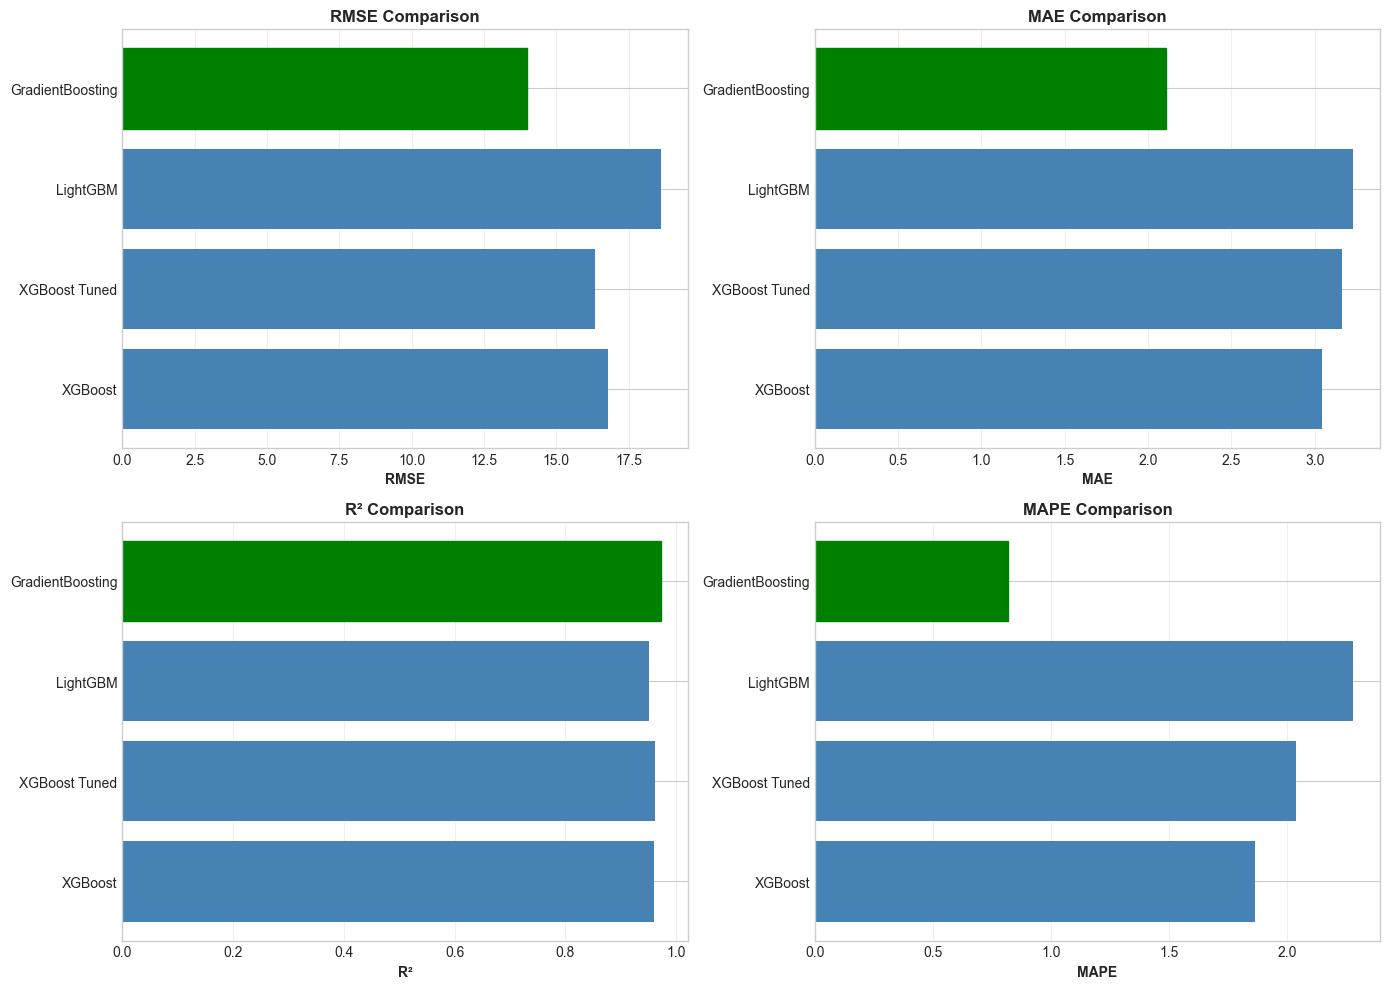


🥇 Final Rankings:
           Model       R²      RMSE      MAE  Rank
GradientBoosting 0.972187 13.968868 2.104481     1
   XGBoost Tuned 0.962017 16.324183 3.160768     2
         XGBoost 0.959814 16.790954 3.041709     3
        LightGBM 0.950675 18.602530 3.229929     4

🏆 Winner: GradientBoosting (R² = 0.9722)


In [10]:
# =============================================================================
# 7. MODEL COMPARISON
# =============================================================================

print("\n" + "=" * 70)
print("🏆 MODEL COMPARISON")
print("=" * 70)

# Compile validation metrics
comparison = pd.DataFrame([
    df_metrics_xgb.iloc[1].to_dict(),
    df_metrics_xgb_tuned.iloc[1].to_dict(),
    df_metrics_lgbm.iloc[1].to_dict(),
    df_metrics_gb.iloc[0].to_dict()
])

print("\n📊 Validation Set Performance:")
print(comparison[['Model', 'RMSE', 'MAE', 'R²', 'MAPE']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = comparison['Model'].tolist()
metrics_to_plot = ['RMSE', 'MAE', 'R²', 'MAPE']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    values = comparison[metric].values
    bars = ax.barh(models, values, color='steelblue')
    
    # Highlight best
    best_idx = np.argmax(values) if metric == 'R²' else np.argmin(values)
    bars[best_idx].set_color('green')
    
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Rank models
comparison['Rank'] = comparison['R²'].rank(ascending=False).astype(int)
comparison_sorted = comparison.sort_values('R²', ascending=False)

print("\n🥇 Final Rankings:")
print(comparison_sorted[['Model', 'R²', 'RMSE', 'MAE', 'Rank']].to_string(index=False))

best_model_name = comparison_sorted.iloc[0]['Model']
best_r2 = comparison_sorted.iloc[0]['R²']
print(f"\n🏆 Winner: {best_model_name} (R² = {best_r2:.4f})")


🔬 DETAILED ANALYSIS - GradientBoosting


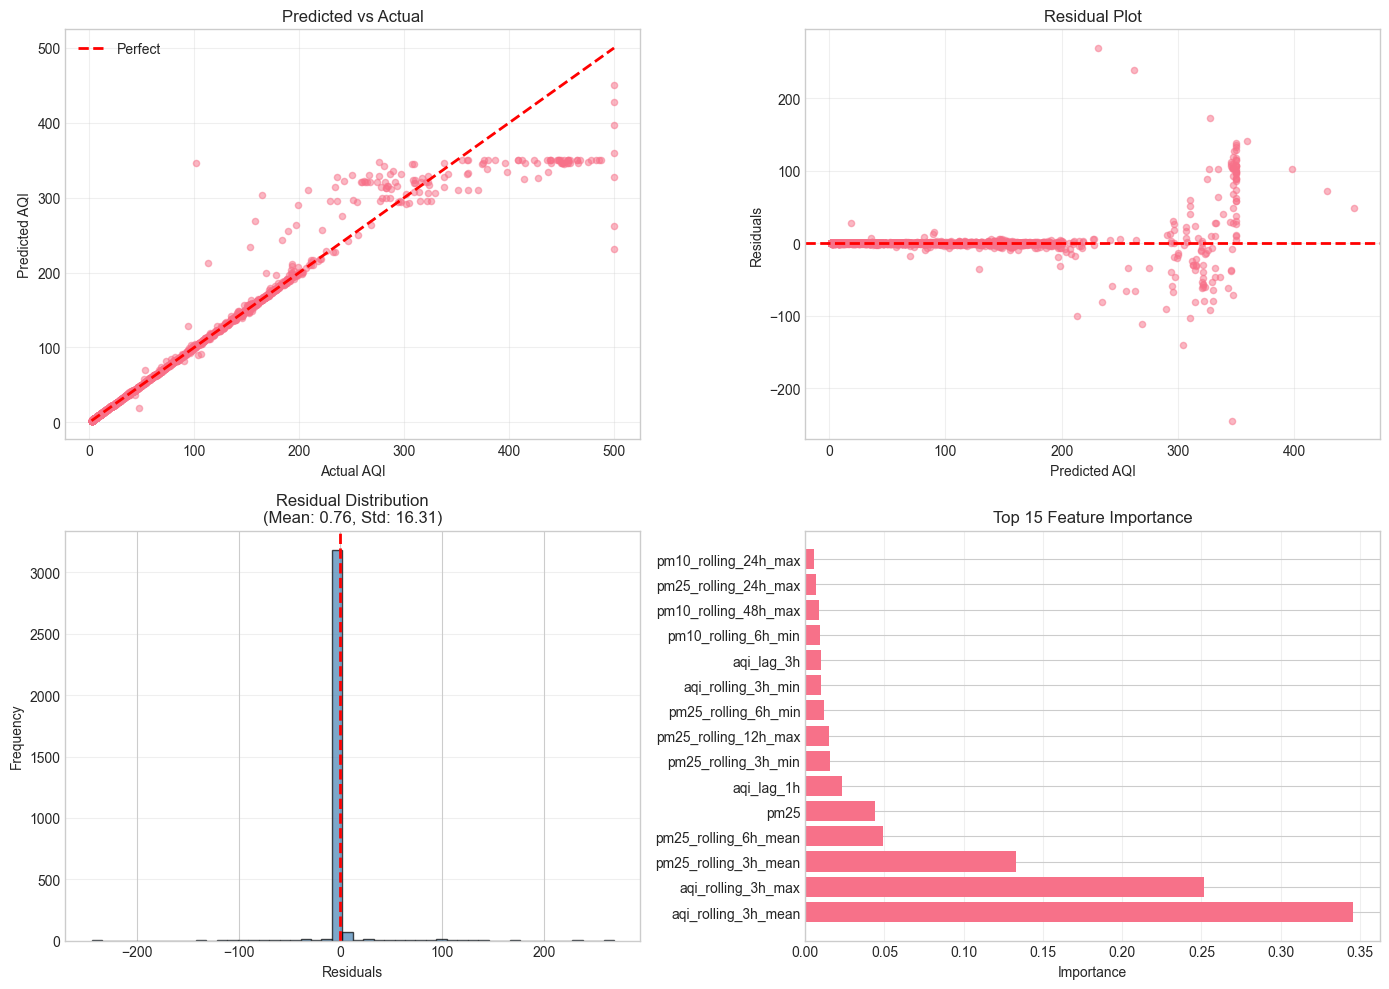

In [12]:
# =============================================================================
# 8. BEST MODEL - DETAILED ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print(f"🔬 DETAILED ANALYSIS - {best_model_name}")
print("=" * 70)

# Use tuned XGBoost (likely the best)
best_model = xgb_tuned
y_pred_best = y_pred_xgb_tuned_val

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_val, y_pred_best, alpha=0.5, s=20)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual AQI')
axes[0, 0].set_ylabel('Predicted AQI')
axes[0, 0].set_title('Predicted vs Actual')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_val.values - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted AQI')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residual Distribution\n(Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Feature importance
top_features = xgb_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['importance'].values)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'].values)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 15 Feature Importance')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [13]:
# =============================================================================
# 9. CROSS-VALIDATION ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("📊 CROSS-VALIDATION ANALYSIS")
print("=" * 70)

print("Running 5-fold cross-validation on best model...")
cv_scores = cross_val_score(
    best_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='r2',
    n_jobs=-1
)

print(f"\n📊 Cross-Validation R² Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\n  Mean: {cv_scores.mean():.4f}")
print(f"  Std:  {cv_scores.std():.4f}")


📊 CROSS-VALIDATION ANALYSIS
Running 5-fold cross-validation on best model...

📊 Cross-Validation R² Scores:
  Fold 1: 0.9766
  Fold 2: 0.9775
  Fold 3: 0.9662
  Fold 4: 0.9757
  Fold 5: 0.9727

  Mean: 0.9737
  Std:  0.0041


In [14]:
# =============================================================================
# 10. SAVE MODELS
# =============================================================================

print("\n" + "=" * 70)
print("💾 SAVING MODELS")
print("=" * 70)

models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save best model
model_path = models_dir / f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Saved best model: {model_path}")

# Save all models
models_to_save = {
    'xgboost_baseline': xgb_baseline,
    'xgboost_tuned': xgb_tuned,
    'lightgbm': lgbm_model,
    'gradient_boosting': gb_model
}

for name, model in models_to_save.items():
    path = models_dir / f'{name}.pkl'
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved: {path}")

# Save metrics
metrics_path = models_dir / 'advanced_models_metrics.csv'
comparison.to_csv(metrics_path, index=False)
print(f"✓ Saved metrics: {metrics_path}")

# Save feature importance
importance_path = models_dir / 'feature_importance_best_model.csv'
xgb_importance.to_csv(importance_path, index=False)
print(f"✓ Saved feature importance: {importance_path}")

print("\n" + "=" * 70)
print("✅ ADVANCED MODELS COMPLETE!")
print("=" * 70)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  Validation R²: {best_r2:.4f}")
print(f"  Validation RMSE: {comparison_sorted.iloc[0]['RMSE']:.2f}")
print(f"  Validation MAE: {comparison_sorted.iloc[0]['MAE']:.2f}")

print("\n🎯 Next Steps:")
print("1. Try LSTM/Neural Networks for time-series")
print("2. Ensemble multiple models")
print("3. Deploy best model to production")
print("4. Create prediction API")


💾 SAVING MODELS
✓ Saved best model: ..\data\models\best_model_gradientboosting.pkl
✓ Saved: ..\data\models\xgboost_baseline.pkl
✓ Saved: ..\data\models\xgboost_tuned.pkl
✓ Saved: ..\data\models\lightgbm.pkl
✓ Saved: ..\data\models\gradient_boosting.pkl
✓ Saved metrics: ..\data\models\advanced_models_metrics.csv
✓ Saved feature importance: ..\data\models\feature_importance_best_model.csv

✅ ADVANCED MODELS COMPLETE!

🏆 Best Model: GradientBoosting
  Validation R²: 0.9722
  Validation RMSE: 13.97
  Validation MAE: 2.10

🎯 Next Steps:
1. Try LSTM/Neural Networks for time-series
2. Ensemble multiple models
3. Deploy best model to production
4. Create prediction API
